## Download the data

In [1]:
import requests

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
dataset_ids = ["daily-shelter-overnight-service-occupancy-capacity", "central-intake-calls"]

for d_id in dataset_ids:
    url = base_url + "/api/3/action/package_show"
    params = { "id": d_id }
    package = requests.get(url, params = params).json()
    
    for idx, resource in enumerate(package["result"]["resources"]):
        if resource["datastore_active"]:
           # Get all records in CSV format:
           url = base_url + "/datastore/dump/" + resource["id"]
           resource_dump_data = requests.get(url).text
           # Save CSV files
           filename = resource['name'].lower().replace(' ', '_')
           f = open(filename + '.csv', "w")
           f.write(resource_dump_data)
           f.close()

## Exploratory Data Analyses

### Daily Shelter Occupancy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 2023 data
df = pd.read_csv('daily_shelter_overnight_occupancy.csv')

# Glimpse data
print(list(df.columns))
print(df.head(10))

['_id', 'OCCUPANCY_DATE', 'ORGANIZATION_ID', 'ORGANIZATION_NAME', 'SHELTER_ID', 'SHELTER_GROUP', 'LOCATION_ID', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_ID', 'PROGRAM_NAME', 'SECTOR', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS']
   _id OCCUPANCY_DATE  ORGANIZATION_ID  \
0    1     2023-01-01               24   
1    2     2023-01-01               24   
2    3     2023-01-01               24   
3    4     2023-01-01               24   
4    5     2023-01-01               24   
5    6     2023-01-01               14   
6    7     2023-01-01               14   
7    8     2023-01-01               14   
8    9     2023

In [3]:
## Summary Stats

# Number of shelters in Toronto
num_shelters = df['LOCATION_ID'].nunique()
print(f'There are {num_shelters} shelter locations in Toronto.')

# Total beds
df_beds = df[df['CAPACITY_TYPE'] == 'Bed Based Capacity']
total_num_beds = int(df[(df['CAPACITY_TYPE'] == 'Bed Based Capacity') & (df['OCCUPANCY_DATE'] == '2023-01-01')]['CAPACITY_ACTUAL_BED'].sum())
print(f'At the start of 2023, there were {total_num_beds} beds available in bed-based shelters.')

# Total rooms
df_rooms = df[df['CAPACITY_TYPE'] == 'Room Based Capacity']
total_num_rooms = int(df[(df['CAPACITY_TYPE'] == 'Room Based Capacity') & (df['OCCUPANCY_DATE'] == '2023-01-01')]['CAPACITY_ACTUAL_ROOM'].sum())
print(f'At the start of 2023, there were {total_num_rooms} rooms available in room-based shelters.')


There are 108 shelter locations in Toronto.
At the start of 2023, there were 3602 beds available in bed-based shelters.
At the start of 2023, there were 3206 rooms available in room-based shelters.


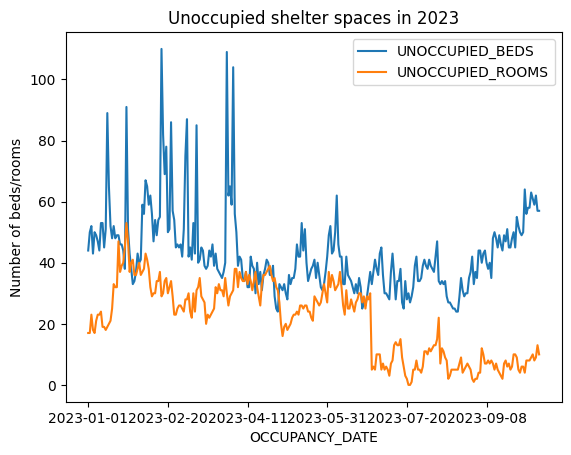

In [4]:
## Trends over time

# Free beds/rooms overall

# Free beds
df_beds = df[df['CAPACITY_TYPE'] == 'Bed Based Capacity']
df_beds_capacity = df_beds[['OCCUPANCY_DATE', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS']].groupby(['OCCUPANCY_DATE']).sum()
# print(df_beds_capacity)

df_beds_capacity["PERCENT_UNOCCUPIED_BEDS"] = df_beds_capacity['UNOCCUPIED_BEDS'] / (df_beds_capacity['UNOCCUPIED_BEDS'] + df_beds_capacity['OCCUPIED_BEDS'])

df_beds_capacity['UNOCCUPIED_BEDS'].plot()

# Free rooms
df_rooms = df[df['CAPACITY_TYPE'] == 'Room Based Capacity']
df_rooms_capacity = df_rooms[['OCCUPANCY_DATE', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS']].groupby(['OCCUPANCY_DATE']).sum()
# print(df_rooms_capacity)

df_rooms_capacity["PERCENT_UNOCCUPIED_ROOMS"] = df_rooms_capacity['UNOCCUPIED_ROOMS'] / (df_rooms_capacity['UNOCCUPIED_ROOMS'] + df_rooms_capacity['OCCUPIED_ROOMS'])

df_rooms_capacity['UNOCCUPIED_ROOMS'].plot()

plt.title('Unoccupied shelter spaces in 2023')
plt.ylabel('Number of beds/rooms')
plt.legend()


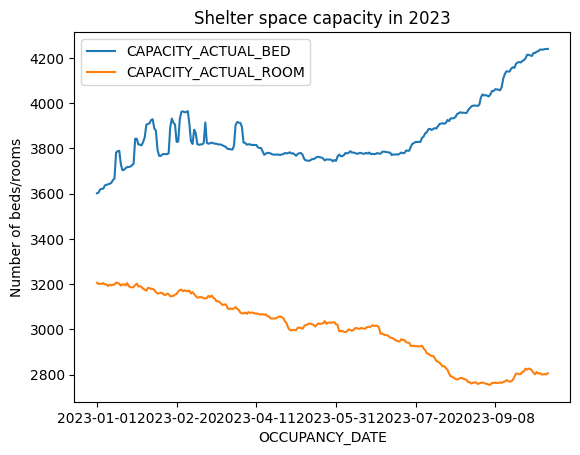

In [5]:
# Plot Shelter space capacity for beds and rooms

df_beds_capacity['CAPACITY_ACTUAL_BED'].plot()
df_rooms_capacity['CAPACITY_ACTUAL_ROOM'].plot()

plt.title('Shelter space capacity in 2023')
plt.ylabel('Number of beds/rooms')
plt.legend()

Text(0, 0.5, 'Number of beds')

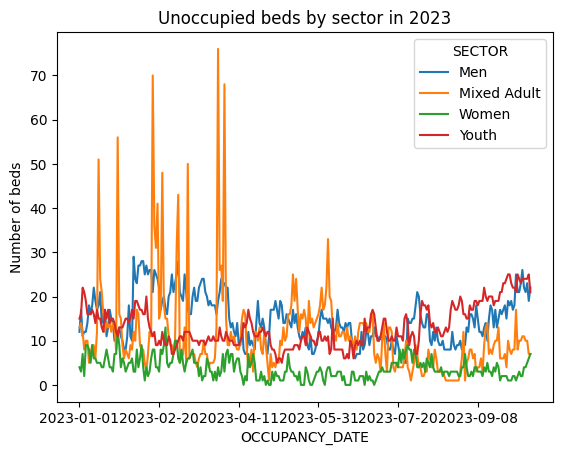

In [6]:
# Plot Unoccupied beds by sector

df_beds = df[df['CAPACITY_TYPE'] == 'Bed Based Capacity']
df_beds_capacity = df_beds[['OCCUPANCY_DATE', 'SECTOR', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS']]
# print(df_beds_capacity)

df3 = pd.pivot_table(
    df_beds_capacity,
    values=['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS'],
    index='OCCUPANCY_DATE',
    columns=['SECTOR'],
    aggfunc={
        'CAPACITY_ACTUAL_BED': 'sum',
        'CAPACITY_FUNDING_BED': 'sum',
        'OCCUPIED_BEDS': 'sum',
        'UNOCCUPIED_BEDS': 'sum',
        'UNAVAILABLE_BEDS': 'sum'
    }
)

df3['UNOCCUPIED_BEDS'].plot()
plt.title('Unoccupied beds by sector in 2023')
plt.ylabel('Number of beds')


Text(0, 0.5, 'Number of beds')

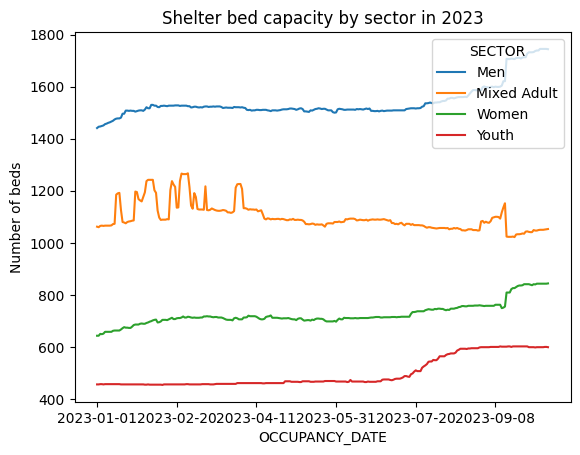

In [7]:
# Plot shelter bed capacity for different sectors

df3['CAPACITY_ACTUAL_BED'].plot()
plt.title('Shelter bed capacity by sector in 2023')
plt.ylabel('Number of beds')

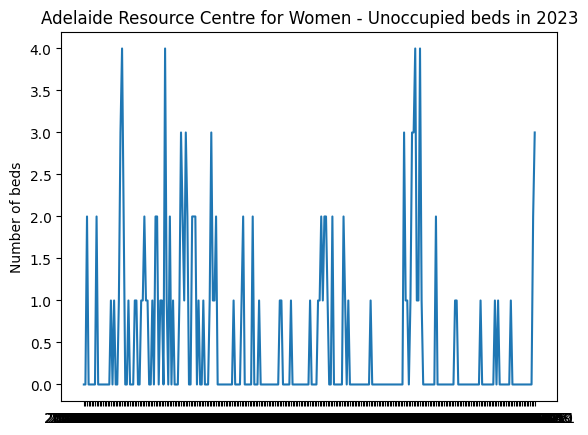

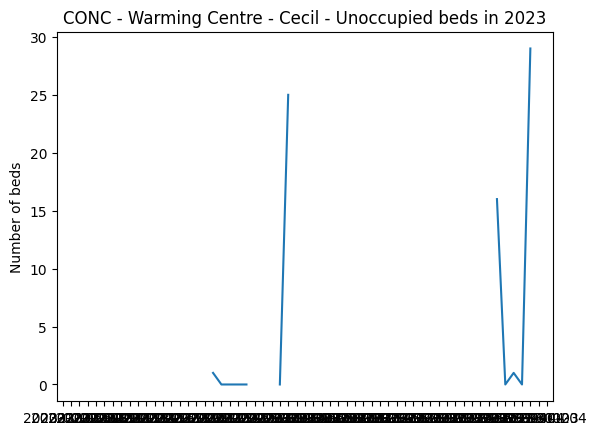

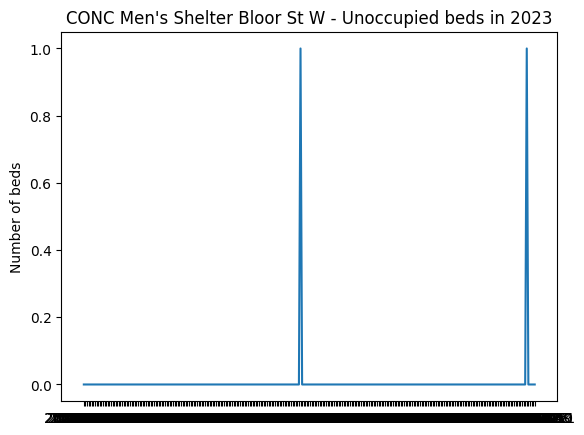

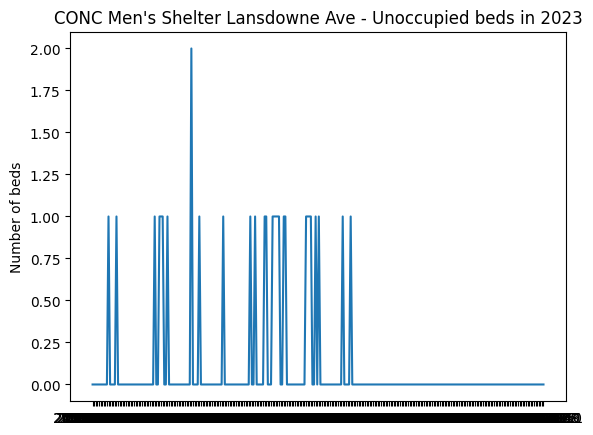

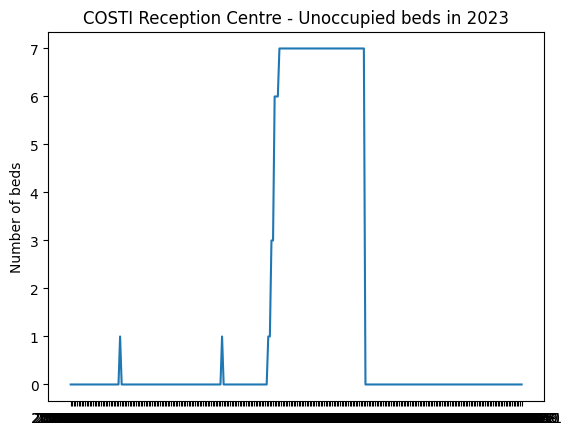

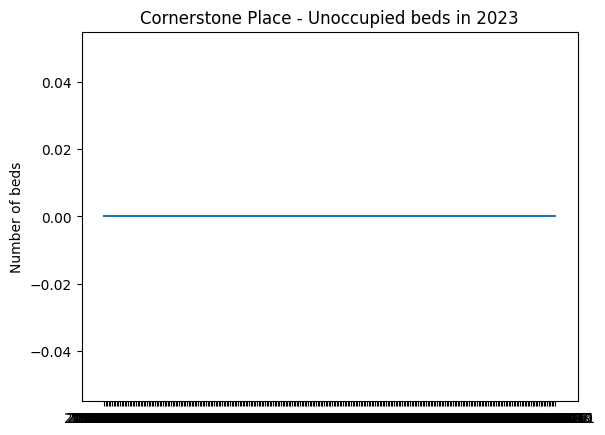

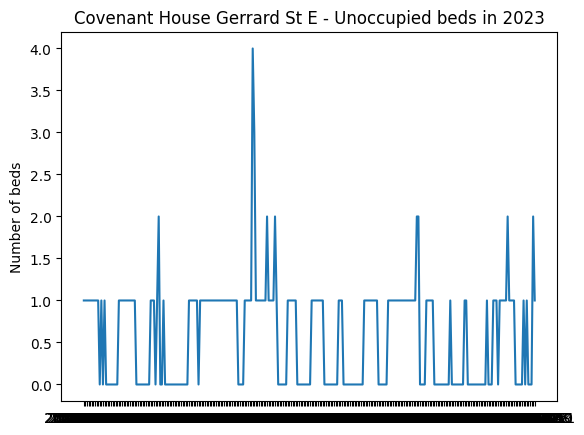

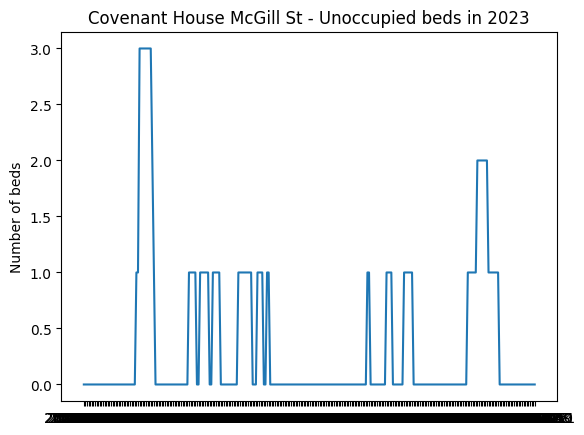

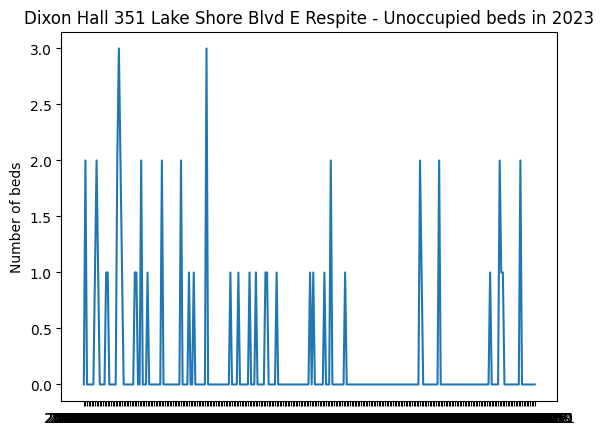

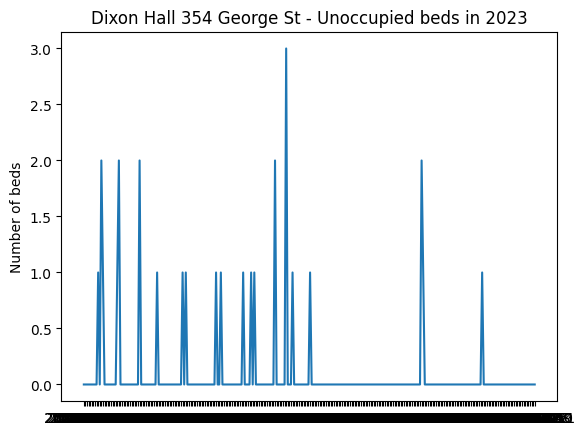

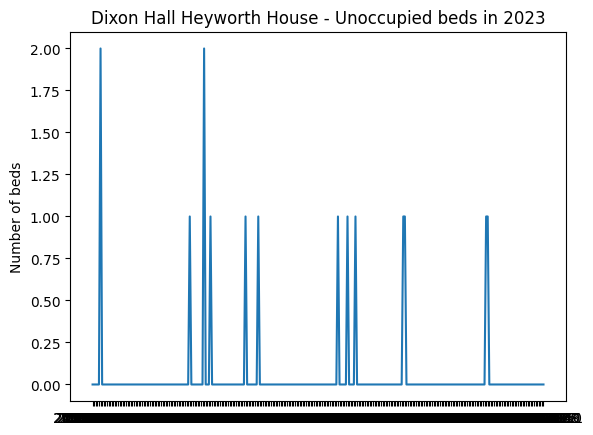

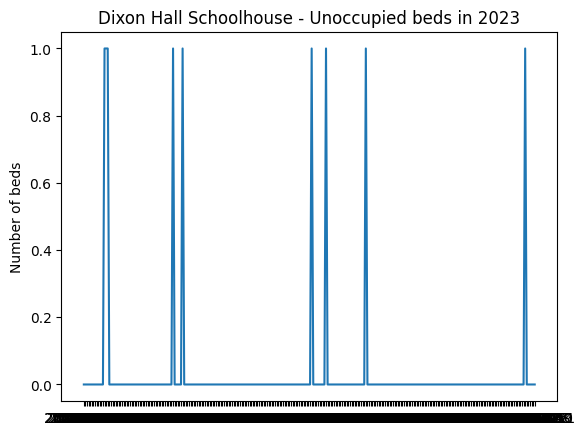

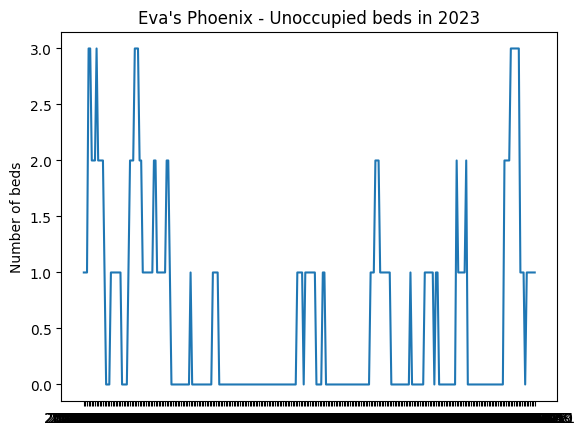

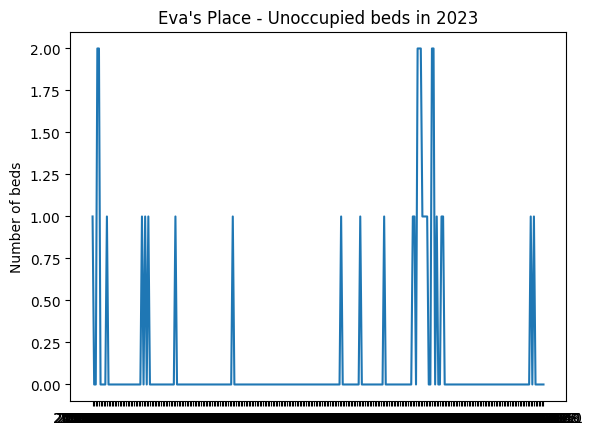

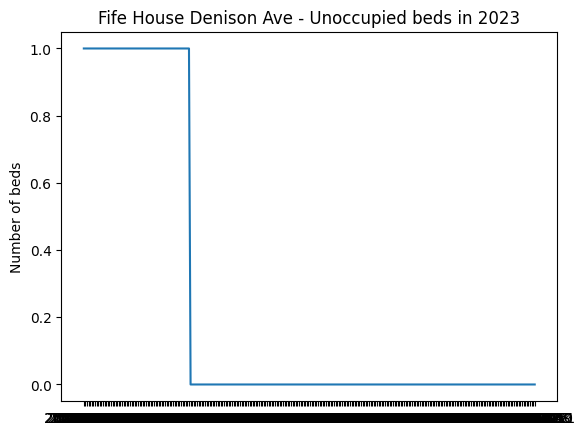

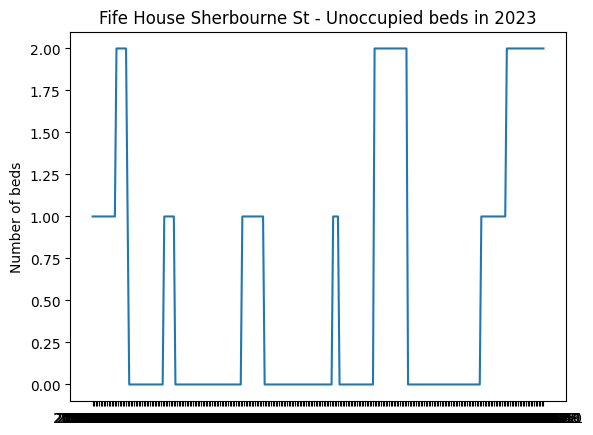

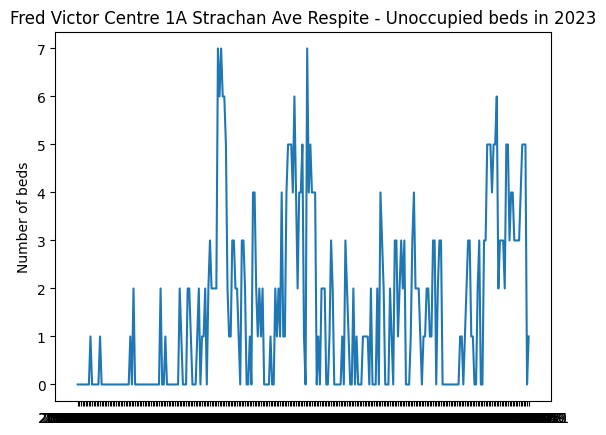

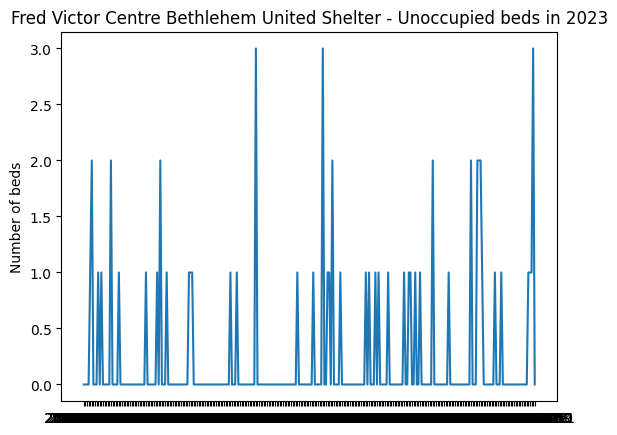

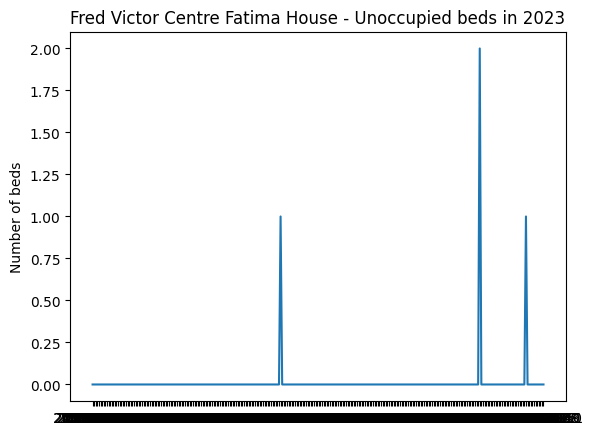

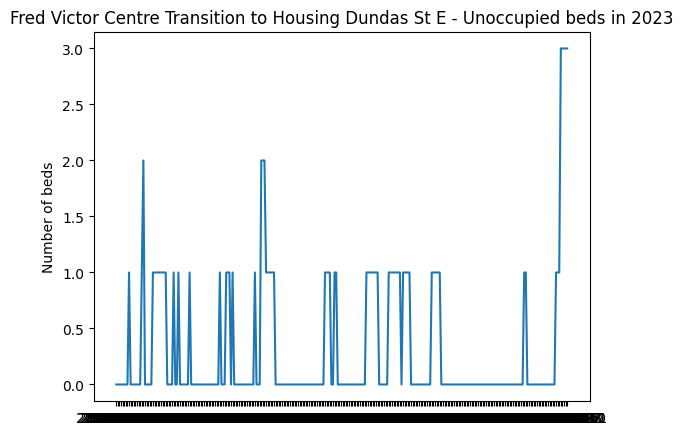

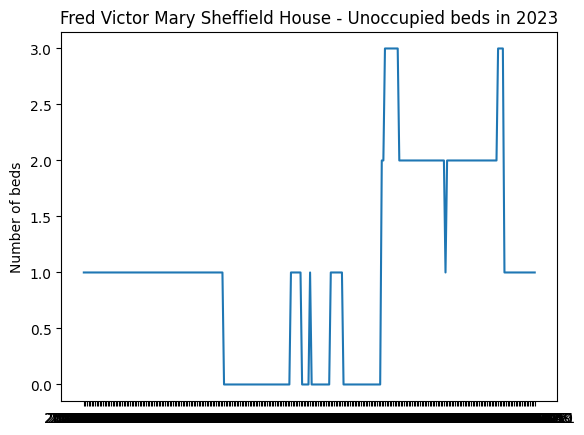

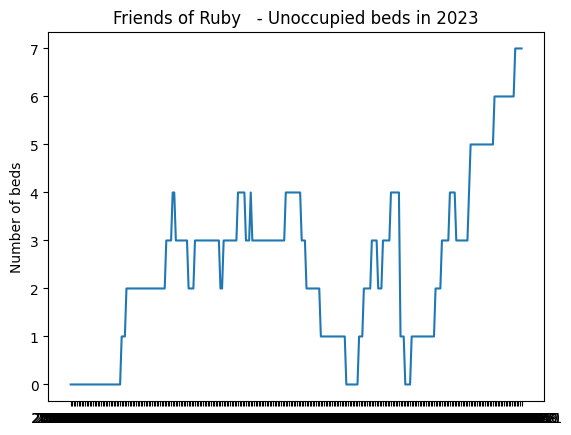

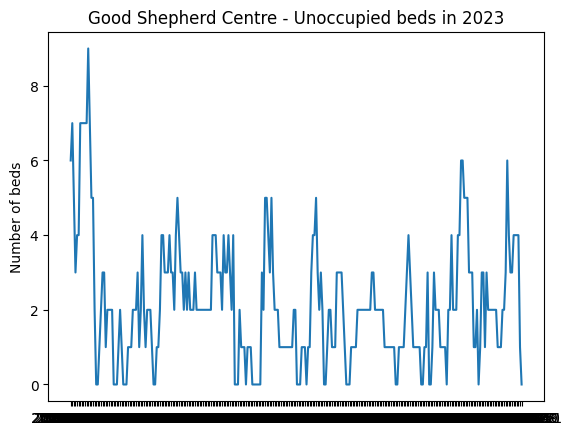

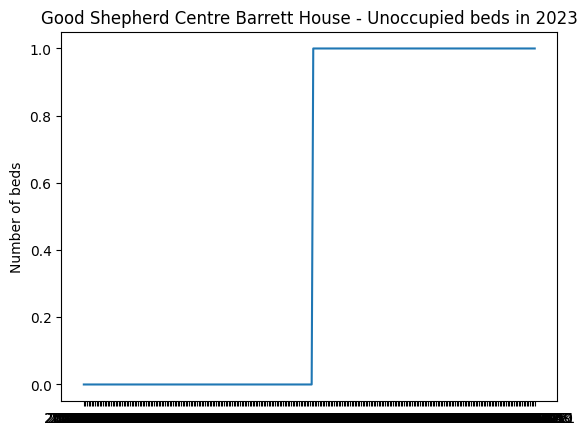

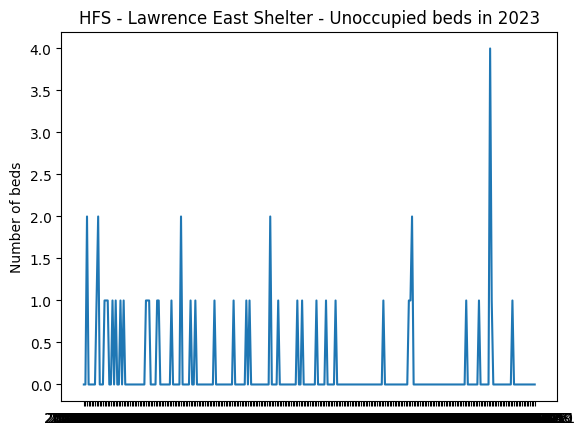

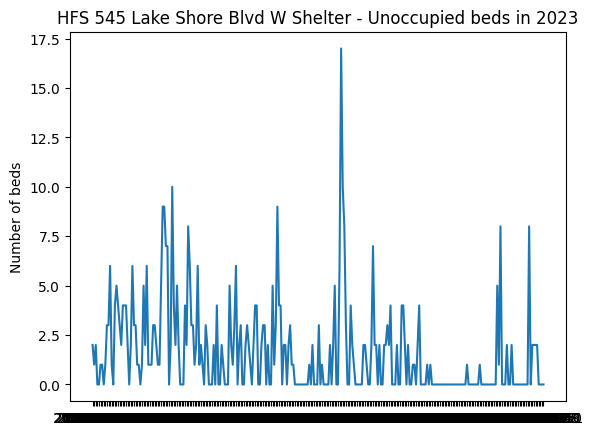

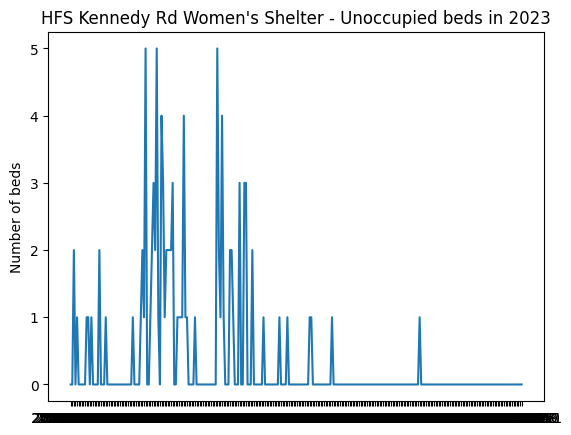

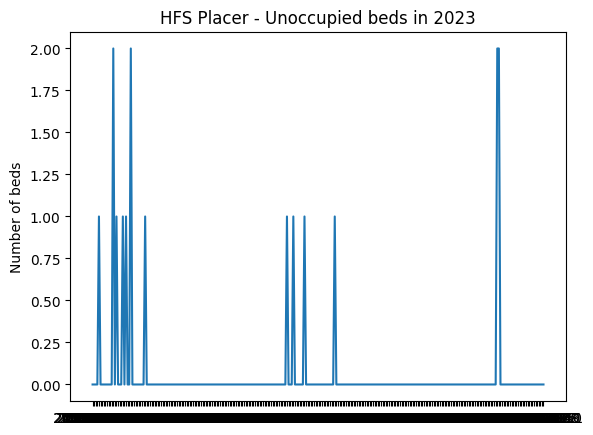

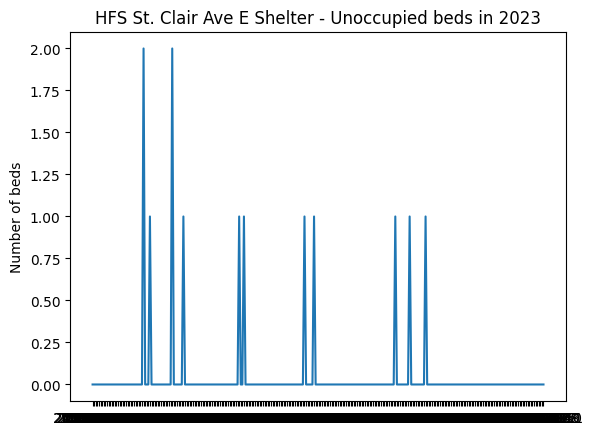

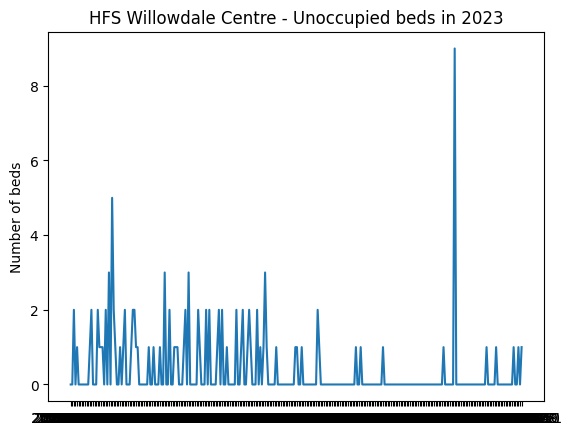

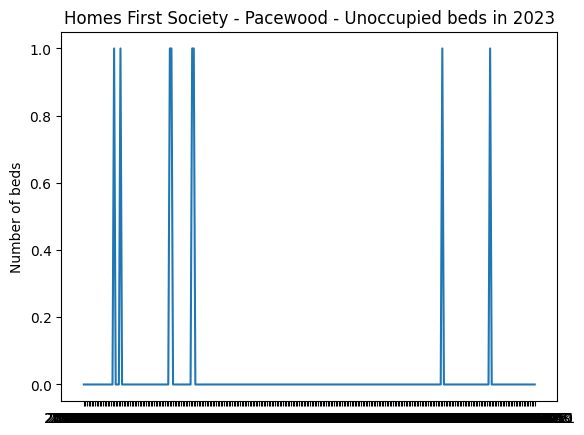

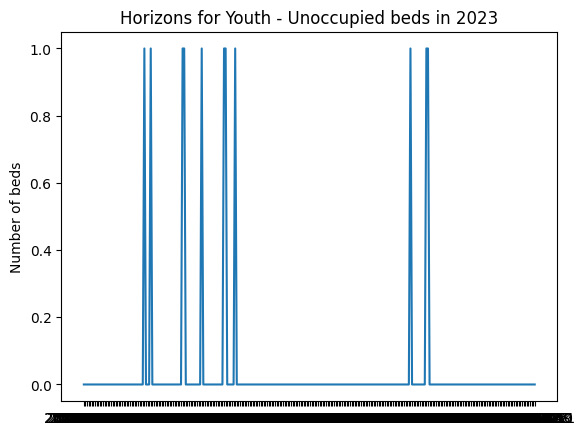

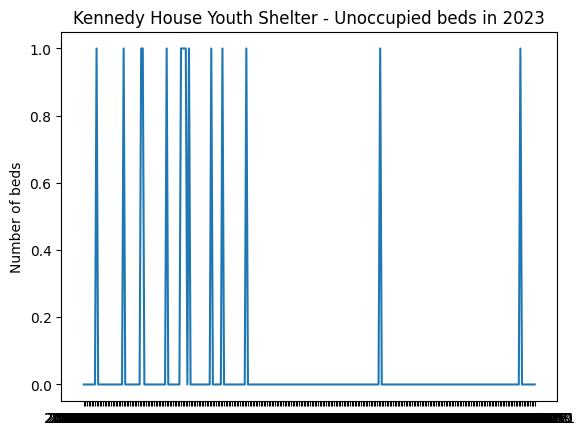

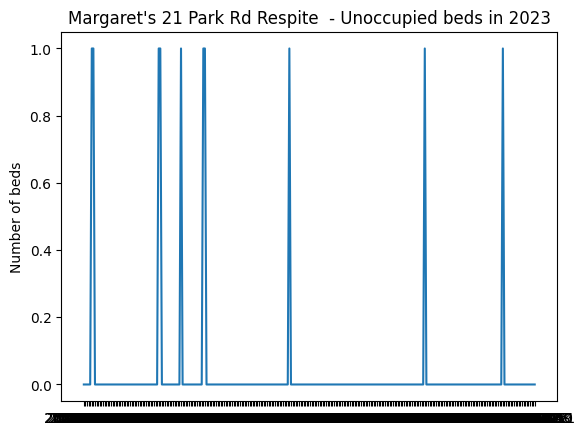

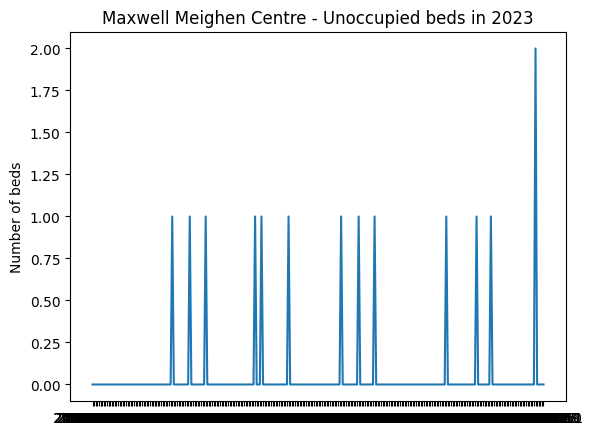

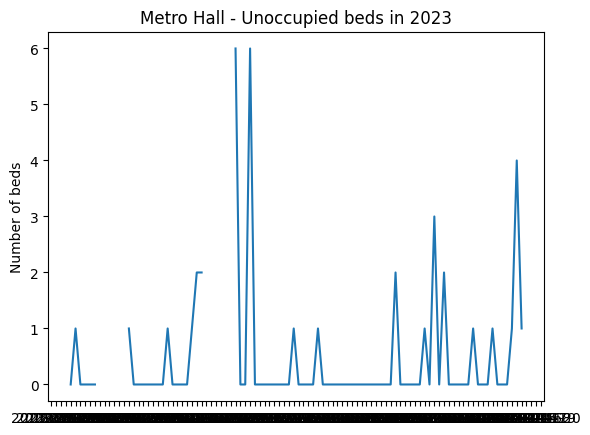

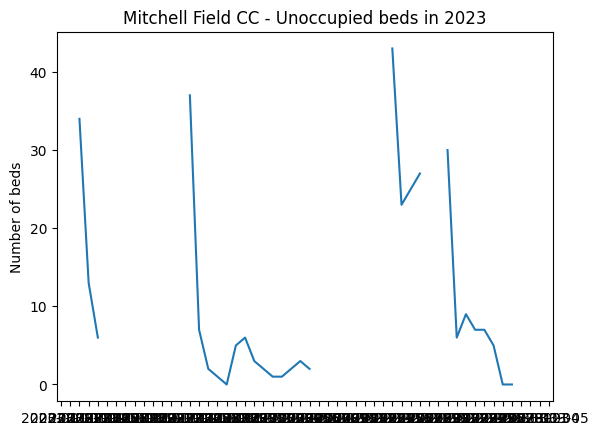

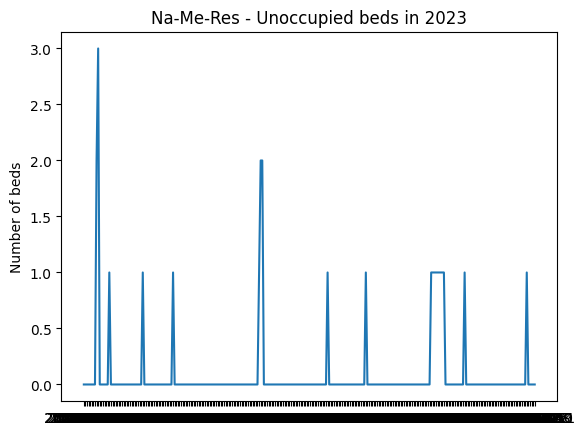

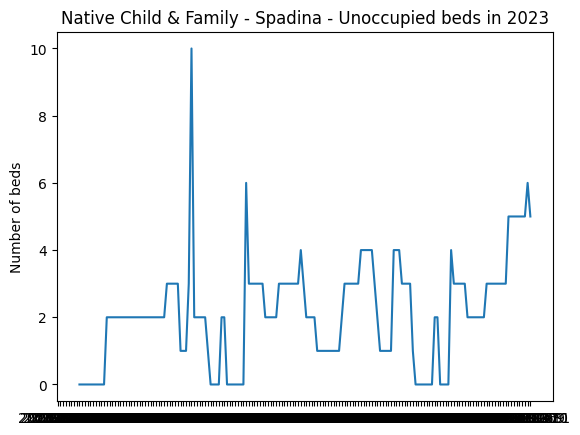

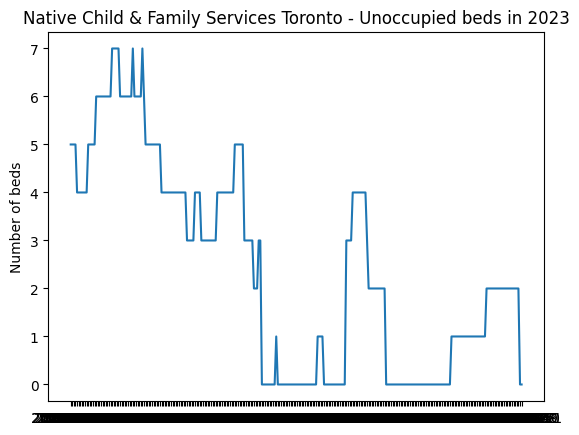

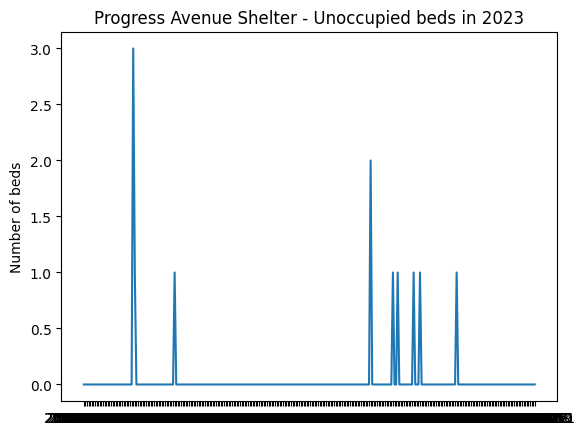

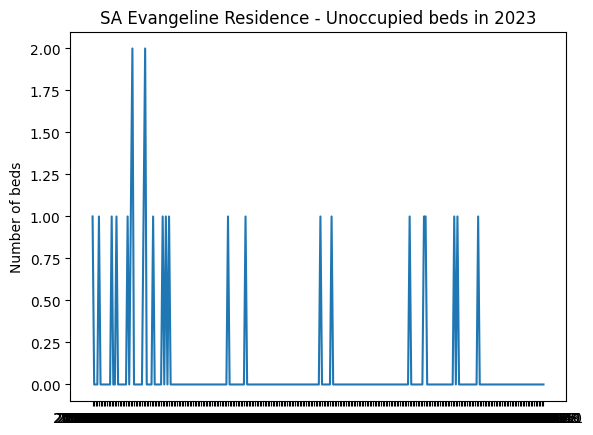

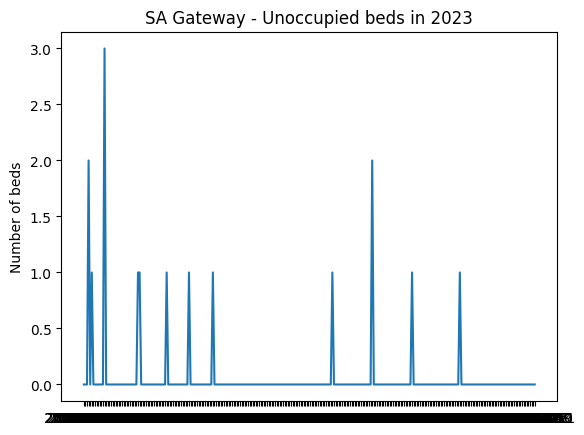

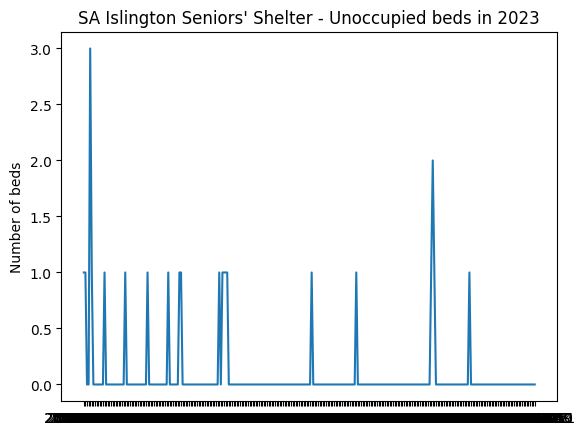

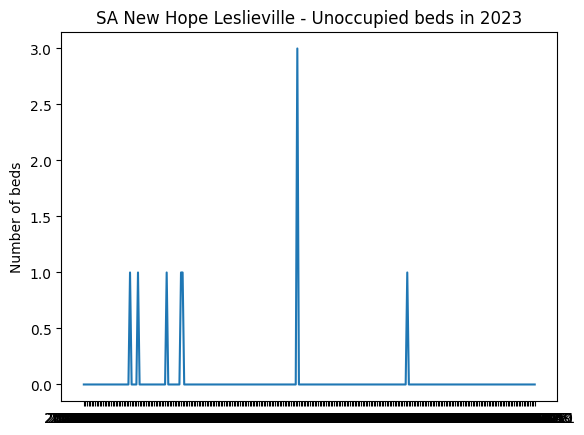

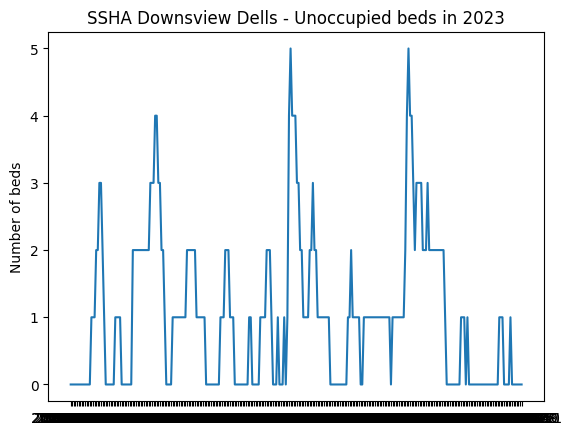

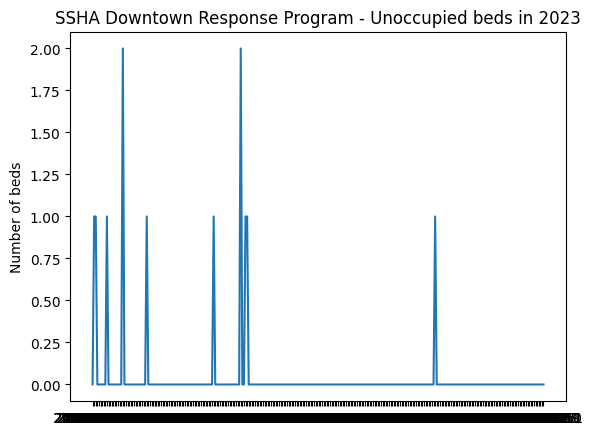

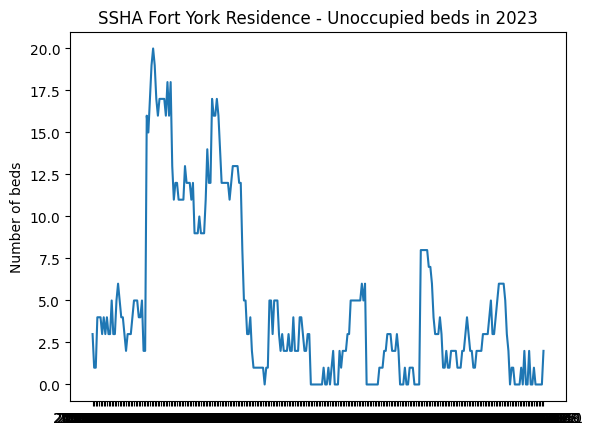

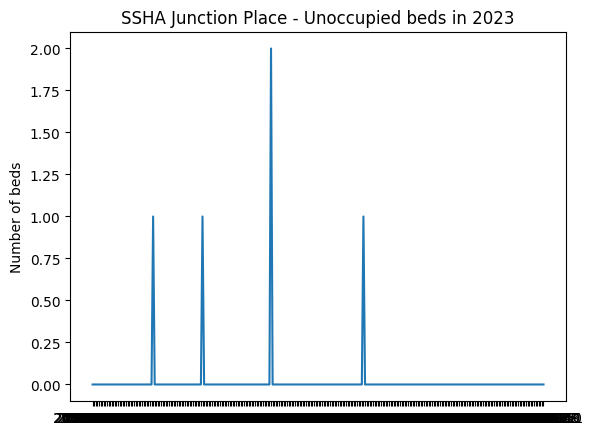

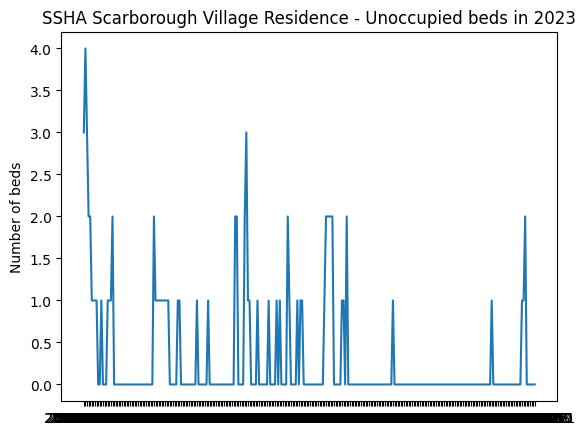

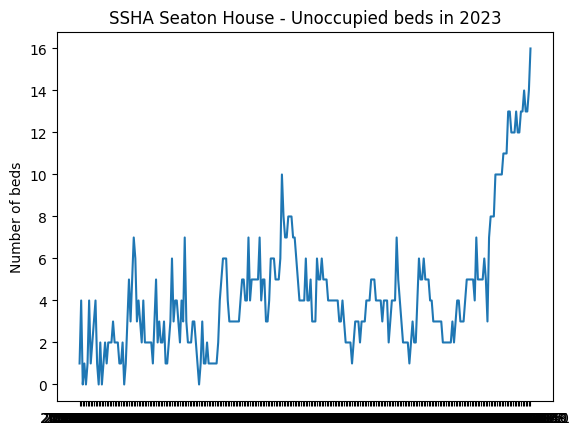

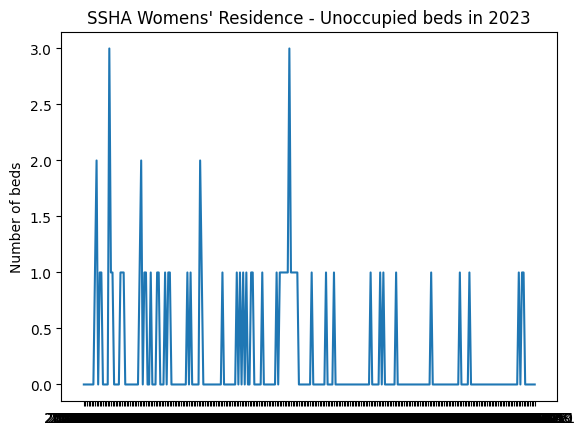

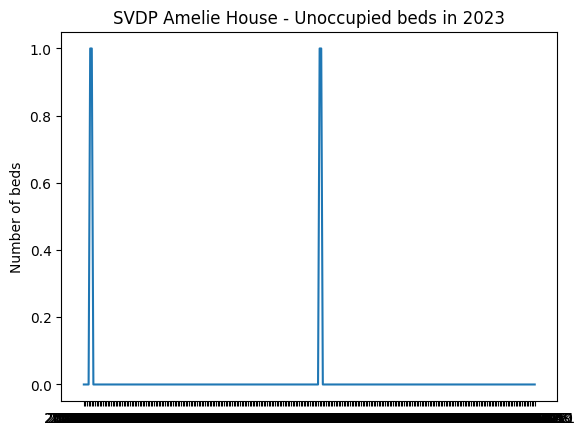

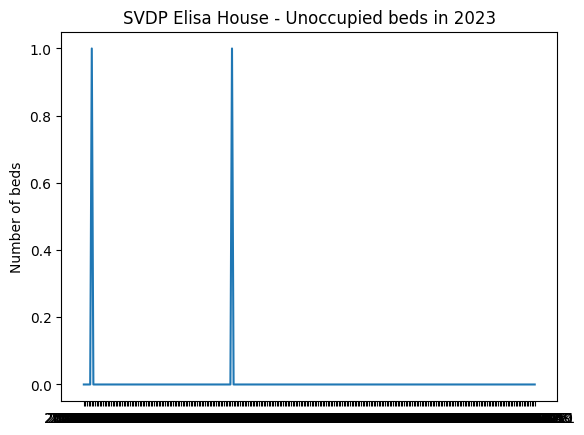

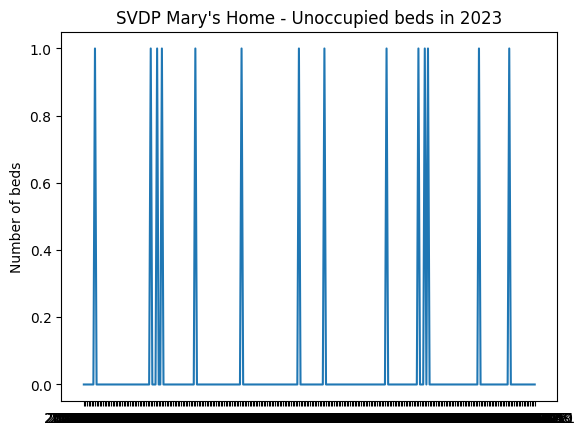

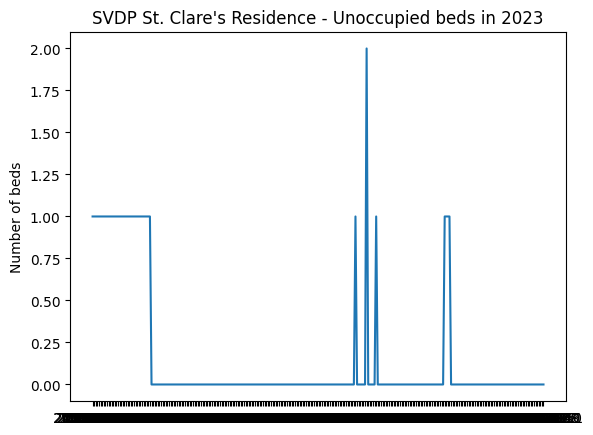

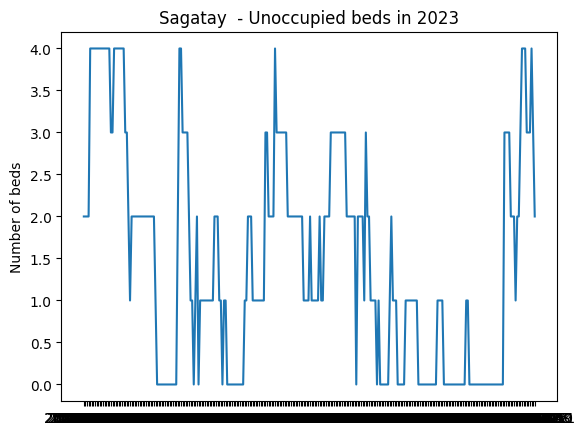

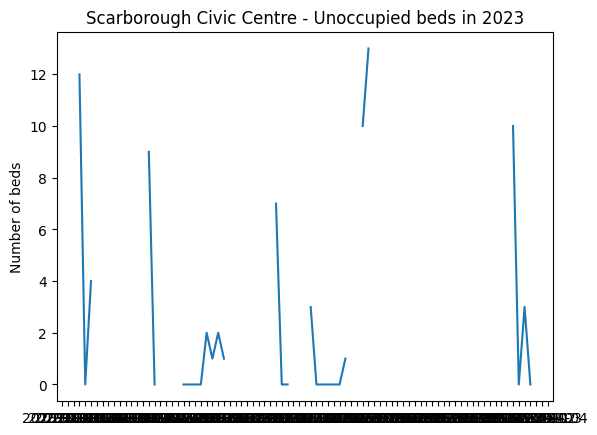

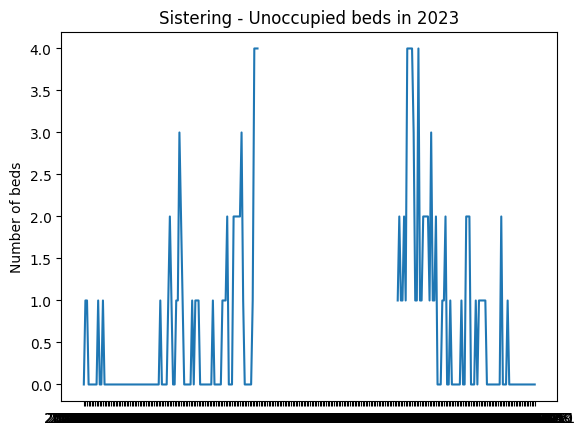

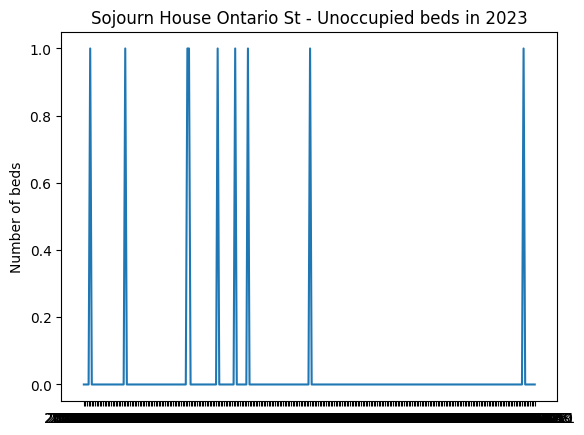

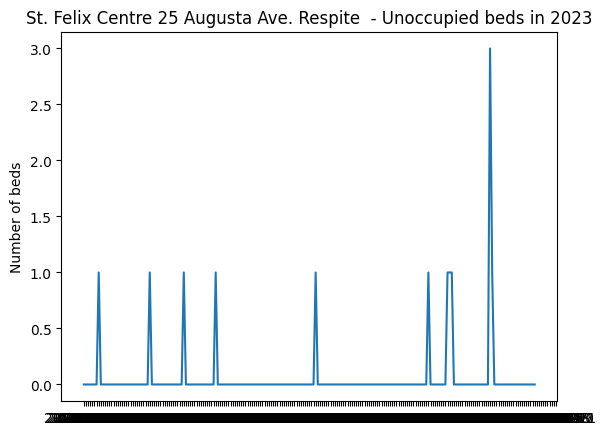

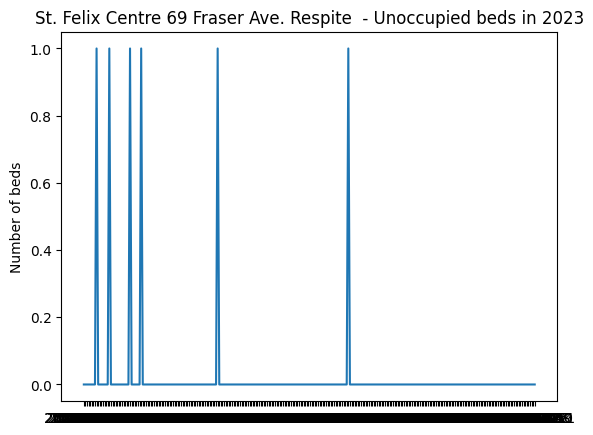

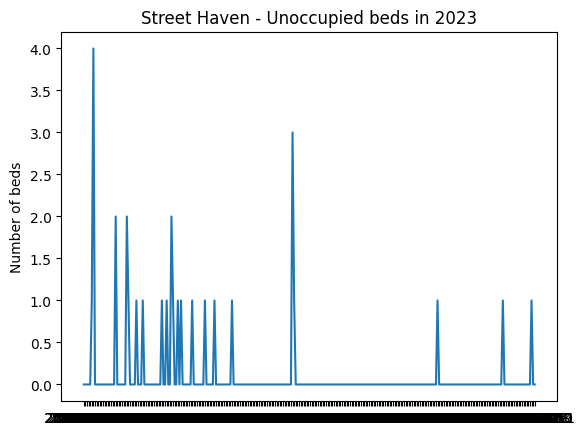

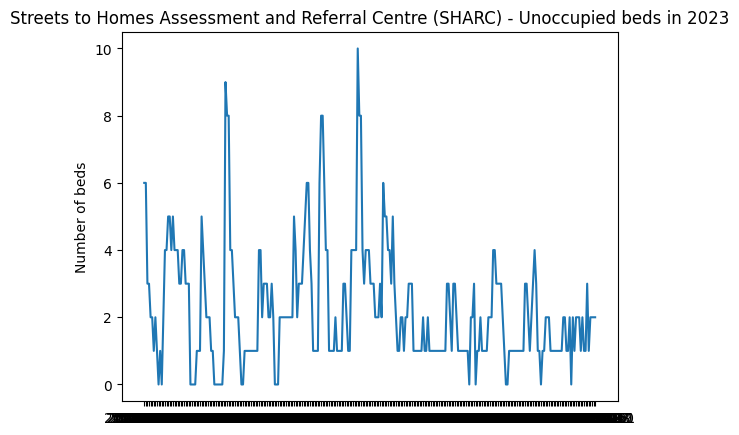

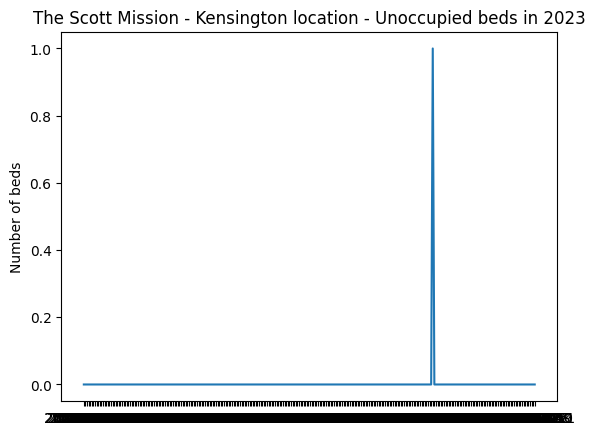

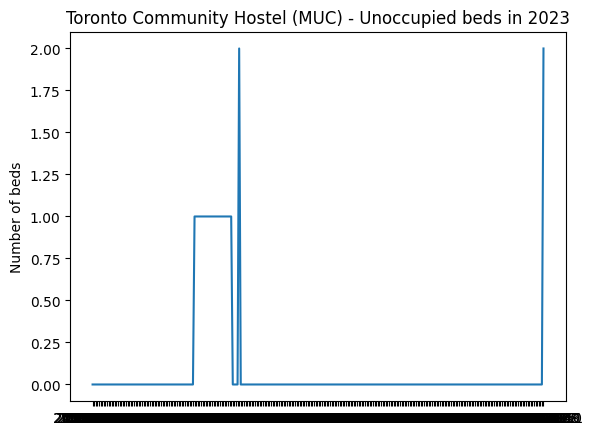

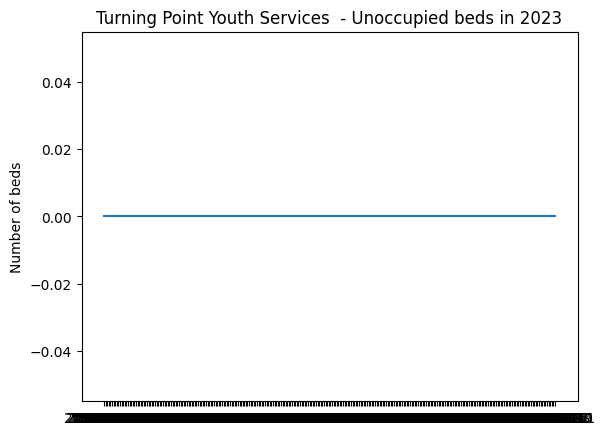

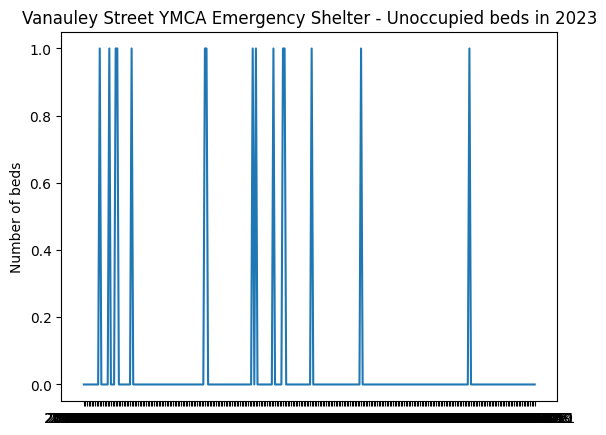

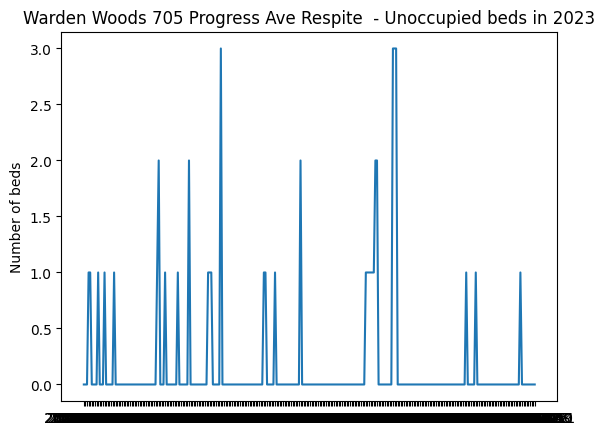

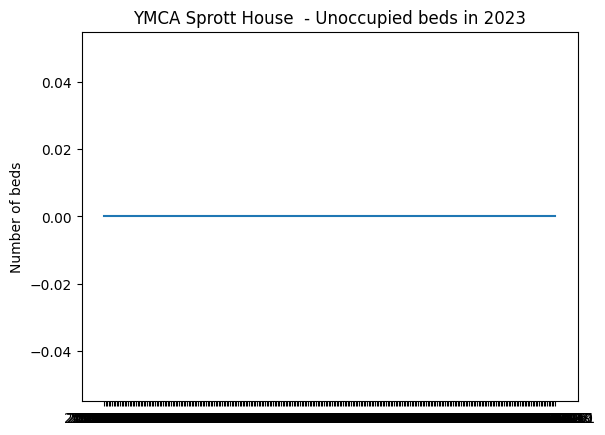

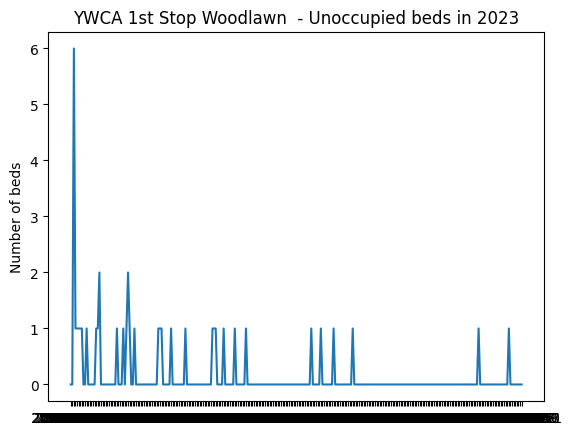

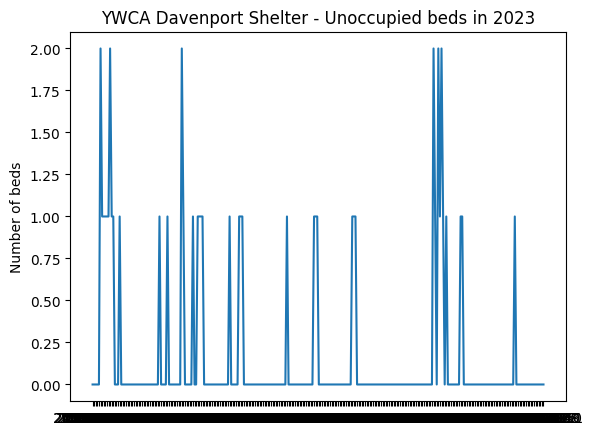

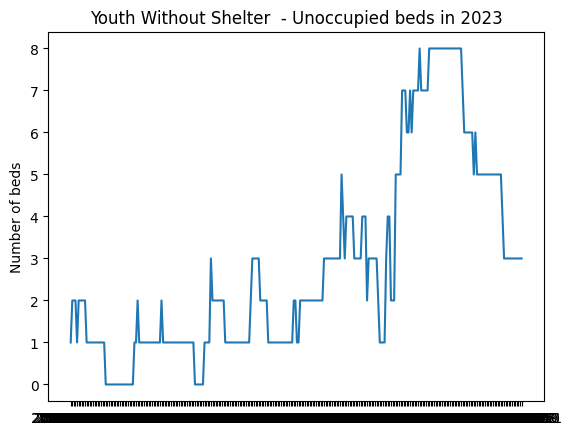

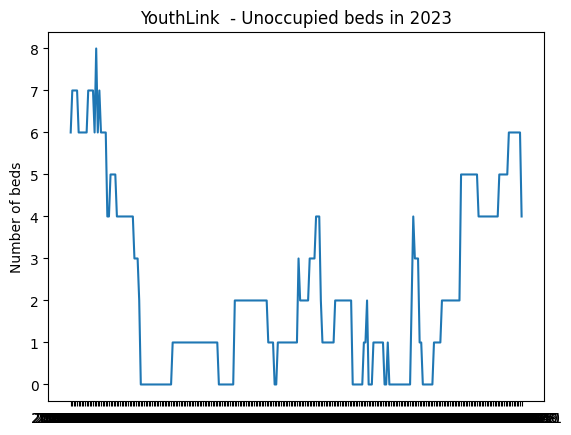

In [8]:
# Plot unoccupied beds for individual shelters

df_beds = df[df['CAPACITY_TYPE'] == 'Bed Based Capacity']
df_beds_capacity = df_beds[['OCCUPANCY_DATE', 'LOCATION_NAME', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS']]
# print(df_beds_capacity)

df4 = pd.pivot_table(
    df_beds_capacity,
    values=['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS'],
    index='OCCUPANCY_DATE',
    columns=['LOCATION_NAME'],
    aggfunc={
        'CAPACITY_ACTUAL_BED': 'sum',
        'CAPACITY_FUNDING_BED': 'sum',
        'OCCUPIED_BEDS': 'sum',
        'UNOCCUPIED_BEDS': 'sum',
        'UNAVAILABLE_BEDS': 'sum'
    }
)

for col in list(df4['UNOCCUPIED_BEDS'].columns):
    plt.plot(df4[('UNOCCUPIED_BEDS',col)])
    plt.title(col + ' - Unoccupied beds in 2023')
    plt.ylabel('Number of beds')
    plt.show()